In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as  plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten,InputLayer,Input
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import ResNet152V2,DenseNet121,InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalseNegatives,FalsePositives
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score

In [ ]:
directory = '/content/Brain Tumour'

In [ ]:
class_names = ['no','yes']

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 253 files belonging to 2 classes.


##Data Preprocessing
##Splits


In [ ]:
def splits(dataset,Train_ratio,Val_ratio,Test_ratio):

    data_size = len(dataset)

    train_dataset = dataset.take(int(data_size*Train_ratio))

    val_split_set = dataset.skip(int(data_size*Train_ratio))

    val_dataset = val_split_set.take((int(data_size*Val_ratio)))

    test_dataset = val_split_set.skip(int(data_size*Test_ratio))
    return train_dataset,val_dataset,test_dataset

Train_ratio = 0.80
Val_ratio = .10
Test_ratio = 0.10
train_dataset,val_dataset,test_dataset  = splits(dataset,Train_ratio,Val_ratio,Test_ratio)

print("The length of the train_dataset is  : ",len(train_dataset))
print('The length of the val_dataset is  : ',len(val_dataset))
print('The length of the test_dataset is  : ',len(test_dataset))

The length of the train_dataset is  :  202
The length of the val_dataset is  :  25
The length of the test_dataset is  :  26


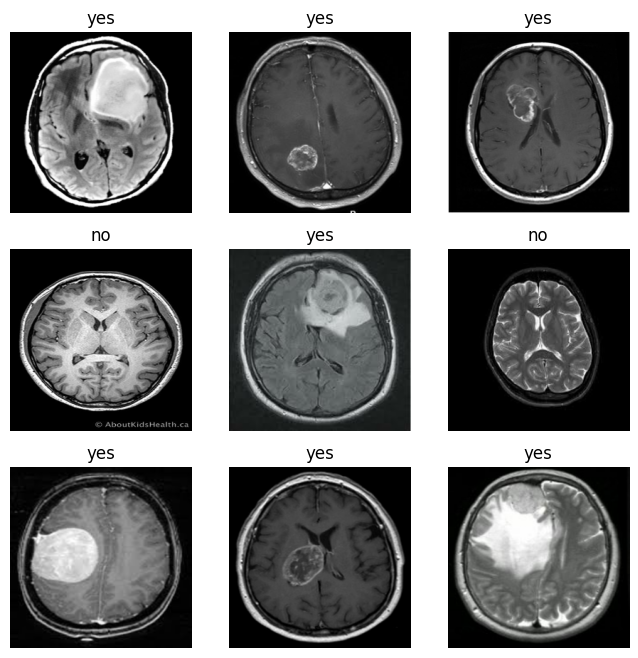

In [ ]:
plt.figure(figsize=(8,8))
for i,(image,label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(class_names[label])
    plt.axis('off')

##Dataset Prepartion

In [ ]:
#resize and rescaling

def resize_rescaling(image,label):

    return tf.image.resize(image,(224,224))/255,label

In [ ]:
train_dataset = (
             train_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(10)
            .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
             val_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(3)
            .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_dataset = (
             test_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
)

##Create Model


In [ ]:
Lenet_model = tf.keras.Sequential([
    InputLayer(shape=(224,224,3)),

    Conv2D(filters=32, kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=2),

    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),

    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=1),

    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),

    BatchNormalization(),

    MaxPooling2D(pool_size=3,strides=1),
    Dropout(0.2),


    Flatten(),

    Dense(64,activation='relu'),
    BatchNormalization(),

    Dense(64,activation='relu'),
    BatchNormalization(),

    Dense(1,activation='sigmoid')
],name='Lenet_model')
Lenet_model.summary()

Model: "Lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 111, 111, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,377 (896.00 KB)

 Trainable params: 228,929 (894.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
Lenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.001),
                   metrics = ['accuracy'])

In [ ]:
checkpoint_path = "/kaggle/working/best_model.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Corrected parameter name and file extension
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [ ]:
history = Lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=30,
                          verbose=1,
                          callbacks = [checkpoint_callback,
                                      early_stopping ]

                         )

Epoch 1/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6088 - loss: 1.3444
Epoch 1: val_loss improved from inf to 1.37563, saving model to /kaggle/working/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - accuracy: 0.6142 - loss: 1.3391 - val_accuracy: 0.4800 - val_loss: 1.3756
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6991 - loss: 1.1670
Epoch 2: val_loss improved from 1.37563 to 1.35499, saving model to /kaggle/working/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.7006 - loss: 1.1664 - val_accuracy: 0.4800 - val_loss: 1.3550
Epoch 3/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8184 - loss: 1.0620
Epoch 3: val_loss did not improve from 1.35499
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.8160 - loss: 1.0630 - val_accuracy: 0.5600 - val_loss: 1.3804
Epoch 4/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7340 - loss: 1.1285
Epoch 4: val_loss did not improve from 1.35499
21/21 ━━━━━━

##Evaluate the model

In [ ]:
def evaluate_model(model,dataset):

    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    accuracy = model.history.history['accuracy']
    val_accuracy = model.history.history['val_accuracy']

    plt.figure(figsize=(14,12))

    # Plot model loss
    plt.subplot(2,2,1)

    plt.plot(val_loss)
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['train_loss','val_loss'])
    plt.grid()

    # Plot model accuracy
    plt.subplot(2,2,2)

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.grid()

    # confusion matrix
    plt.subplot(2,2,3)

    img = []
    labels = []
    for x,y in dataset:
        img.append(x)
        labels.append(y)
    true_label = np.array(labels).flatten()
    predicted = model.predict(np.array(img)[:,0,...])[:,0]

    threshold = 0.5

    cm = confusion_matrix(true_label, predicted > threshold)



    sns.heatmap(cm, annot=True,cmap='Blues',xticklabels=['NO','YES'],yticklabels=['NO','YES'])
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Plot roc curve
    plt.subplot(2,2,4)

    fp, tp, thresholds = roc_curve(true_label, predicted)
    roc_auc = roc_auc_score(true_label,predicted)
    plt.plot(fp,tp, color='blue',  label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")

    plt.grid()

    skip = 2

    for i in range(0, len(thresholds), skip):
      plt.text(fp[i], tp[i], thresholds[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


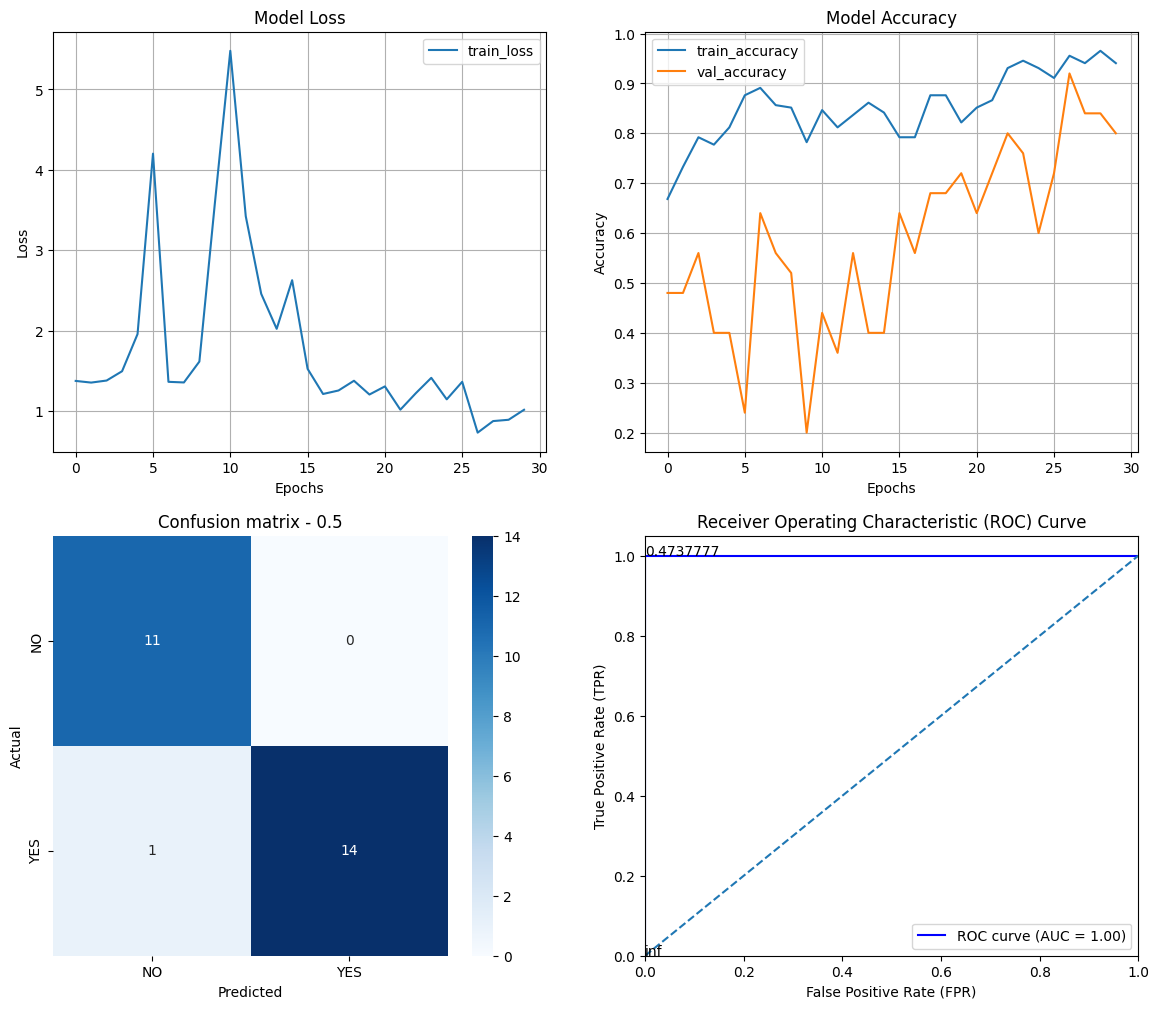

In [ ]:
evaluate_model(Lenet_model,test_dataset)

In [ ]:
test_evaluate = Lenet_model.evaluate(test_dataset)
test_evaluate

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9189 - loss: 0.8714


[0.8573350310325623, 0.8461538553237915]

In [ ]:
val_evaluate = Lenet_model.evaluate(val_dataset)
val_evaluate

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9532 - loss: 0.7848


[0.8044933080673218, 0.8799999952316284]

##Transform Learning


In [ ]:
resnet_backbone = ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape= (224,224,3)
)
inputs = Input(shape=(224,224,3))
x = resnet_backbone(inputs)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1,activation='sigmoid')(x)
Resnet_model = Model(inputs,outputs,name='Resnet_model')
Resnet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
Resnet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=2,
                          verbose=1

                         )

Epoch 1/2
21/21 ━━━━━━━━━━━━━━━━━━━━ 498s 18s/step - accuracy: 0.6392 - loss: 0.6970 - val_accuracy: 0.8400 - val_loss: 0.5648
Epoch 2/2
21/21 ━━━━━━━━━━━━━━━━━━━━ 372s 17s/step - accuracy: 0.8036 - loss: 0.3956 - val_accuracy: 0.8400 - val_loss: 0.2995
